In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
# Set the display format for floating-point numbers
pd.options.display.float_format = '{:.2f}'.format

In [7]:
file_1 = "C:/Users/Efrem/Downloads/meesho_statement_2/DICE Challenge Business Analytics Case 2/clicks__data.csv"
file_2 = "C:/Users/Efrem/Downloads/meesho_statement_2/DICE Challenge Business Analytics Case 2/views__data.csv"
file_3 = "C:/Users/Efrem/Downloads/meesho_statement_2/DICE Challenge Business Analytics Case 2/orders__table.csv"

In [8]:
click_data = pd.read_csv(file_1)
view_data = pd.read_csv(file_2)
order_data = pd.read_csv(file_3)

In [9]:
data = order_data.copy()
data['clicks_count'] = click_data['clicks_count']
data['app_open_count'] = view_data['app_open_count']
data['order_date'] = pd.to_datetime(data['order_date'])
df = data.copy()
data

order_id order_date  user_id  order_value     category  quantity  \
0              0 2023-09-26    14225      4044.37   Home Goods         1   
1              1 2024-09-08    19369      2969.24     Clothing        10   
2              2 2024-03-08      339      4985.45  Electronics         2   
3              3 2023-11-26    19310      4328.57     Clothing         4   
4              4 2023-11-20    13523      2517.05   Home Goods         1   
...          ...        ...      ...          ...          ...       ...   
999995    999995 2023-10-04    11904       896.17   Home Goods         9   
999996    999996 2023-12-14    83686       828.17     Clothing         5   
999997    999997 2024-07-09    37213      4156.44  Electronics         6   
999998    999998 2024-08-17    99950      4931.21   Home Goods         6   
999999    999999 2023-11-17    70793      2315.64     Clothing         9   

       order_status  supplier_id           feedback  clicks_count  \
0         cancelled          565  Negative feedback             1   
1         cancelled          222  Positive feedback            11   
2         cancelled          907   Neutral feedback            44   
3         delivered          176   Neutral feedback            37   
4         delivered          207  Negative feedback            10   
...             ...          ...                ...           ...   
999995    cancelled          769  Negative feedback            16   
999996     returned          968  Positive feedback             7   
999997    delivered          745   Neutral feedback             6   
999998    exchanged          423  Negative feedback             5   
999999          RTO           37   Neutral feedback             3   

        app_open_count  
0                    4  
1                   46  
2                   48  
3                   42  
4                   19  
...                ...  
999995              35  
999996              27  
999997               7  
999998               8  
999999              15  

[1000000 rows x 11 columns]

In [10]:
# Create a new column to indicate if an order was returned
df['is_returned'] = df['order_status'].apply(lambda x: 1 if x == 'returned' or x == 'RTO' else 0)
df['returned'] = df['order_status'].apply(lambda x: 1 if x == 'returned' else 0)
df['RTO'] = df['order_status'].apply(lambda x: 1 if x == 'RTO' else 0)

# Calculate the number of returned orders per user
return_frequency_per_user = df.groupby('user_id')['is_returned'].sum().reset_index()
return_frequency_per_user.columns = ['user_id', 'return_frequency']

# Calculate the total number of orders per user
total_orders_per_user = df.groupby('user_id')['order_id'].count().reset_index()
total_orders_per_user.columns = ['user_id', 'total_orders']

# Merge the two DataFrames to calculate the return rate
return_rate_per_user = pd.merge(return_frequency_per_user, total_orders_per_user, on='user_id')

# Calculate return rate: number of returned orders / total orders
return_rate_per_user['return_rate'] = return_rate_per_user['return_frequency'] / return_rate_per_user['total_orders']

df['return_rate'] = return_rate_per_user['return_rate']

f1 = df.groupby('user_id')['returned'].sum().reset_index()
return_rate_per_user['returned'] = f1['returned']
f2 = df.groupby('user_id')['RTO'].sum().reset_index()
return_rate_per_user['RTO'] = f2['RTO']


# Display the result
return_rate_per_user


user_id  return_frequency  total_orders  return_rate  returned  RTO
0            1                 2            14         0.14         0    2
1            2                 6            13         0.46         1    5
2            3                 3             8         0.38         1    2
3            4                 5            14         0.36         4    1
4            5                 3             9         0.33         1    2
...        ...               ...           ...          ...       ...  ...
99984    99996                 3            10         0.30         1    2
99985    99997                 5             8         0.62         2    3
99986    99998                 2            11         0.18         0    2
99987    99999                 1            12         0.08         0    1
99988   100000                 4             8         0.50         2    2

[99989 rows x 6 columns]

C:\Users\Efrem\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Efrem\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


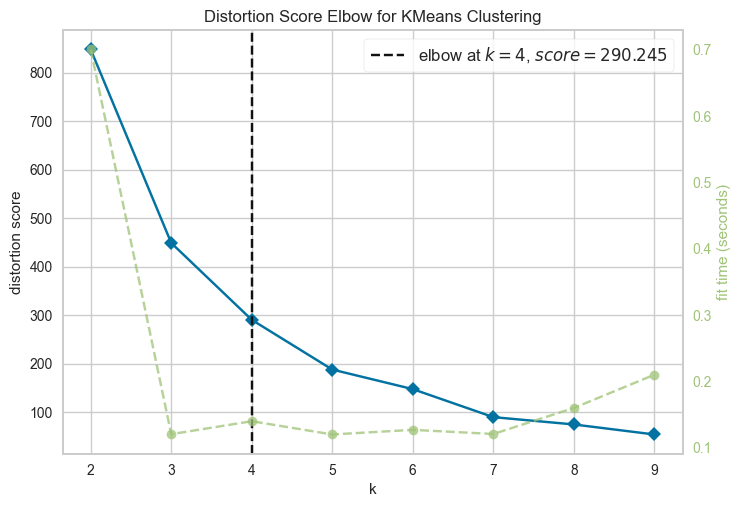

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
km = KMeans(random_state = 42)
visualizer = KElbowVisualizer(km, k = (2,10))
visualizer.fit(return_rate_per_user[['return_rate']])
visualizer.show()

In [12]:
data = return_rate_per_user
# Select the columns you want to apply KMeans on
columns = ['return_rate']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Initialize an empty dictionary to store the cluster scores for each column
cluster_scores = {}

# Apply KMeans clustering for each feature
for i, column in enumerate(columns):
    kmeans = KMeans(n_clusters=4, random_state=0)  # Use n_clusters=4 or any number based on your preference
    data[f'{column}_Cluster'] = kmeans.fit_predict(data_scaled[:, i].reshape(-1, 1))
    
    # Store the cluster labels
    cluster_scores[column] = data[f'{column}_Cluster']

# Print the dataframe with cluster labels
data

user_id  return_frequency  total_orders  return_rate  returned  RTO  \
0            1                 2            14         0.14         0    2   
1            2                 6            13         0.46         1    5   
2            3                 3             8         0.38         1    2   
3            4                 5            14         0.36         4    1   
4            5                 3             9         0.33         1    2   
...        ...               ...           ...          ...       ...  ...   
99984    99996                 3            10         0.30         1    2   
99985    99997                 5             8         0.62         2    3   
99986    99998                 2            11         0.18         0    2   
99987    99999                 1            12         0.08         0    1   
99988   100000                 4             8         0.50         2    2   

       return_rate_Cluster  
0                        2  
1                        1  
2                        3  
3                        3  
4                        3  
...                    ...  
99984                    3  
99985                    1  
99986                    0  
99987                    2  
99988                    1  

[99989 rows x 7 columns]

In [13]:
d1 = return_rate_per_user.groupby('return_rate_Cluster')\
                        .agg({'return_frequency':'mean','total_orders':'mean','return_rate':'mean','returned':'mean','RTO':'mean'}).reset_index()
#d1['return_rate_Cluster'] = d1['return_rate_Cluster'].map({0:1,1:3,2:0,3:2})
d1['total_orders'] = d1['total_orders']/10
d1['return_frequency'] = d1['return_frequency']/10
d1

# Columns to normalize
cols_to_normalize = [ 'total_orders','returned', 'RTO']

# Apply MinMaxScaler to normalize between 0 and 1
scaler = StandardScaler()
d1[cols_to_normalize] = scaler.fit_transform(d1[cols_to_normalize])
d1

return_rate_Cluster  return_frequency  total_orders  return_rate  returned  \
0                    0              0.24          0.93         0.23     -0.40   
1                    1              0.49         -1.15         0.54      1.27   
2                    2              0.08         -0.83         0.08     -1.40   
3                    3              0.38          1.06         0.36      0.52   

    RTO  
0 -0.41  
1  1.28  
2 -1.39  
3  0.51

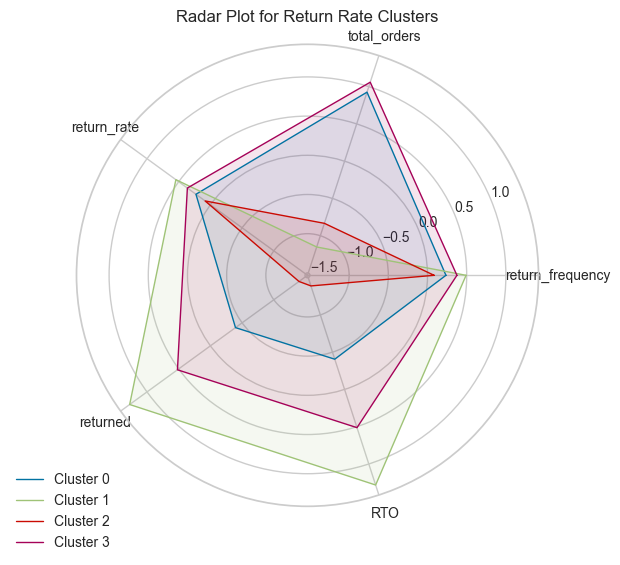

In [14]:
from math import pi

# Set data for radar plot
categories = list(d1.columns[1:])  # Ignore 'return_rate_Cluster'
N = len(categories)

# Create radar plot for each cluster
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i in range(len(d1)):
    values = d1.iloc[i, 1:].values.flatten().tolist()
    values += values[:1]  # Repeat the first value at the end to close the polygon
    # Compute angle for each axis
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {d1["return_rate_Cluster"][i]}')
    ax.fill(angles, values, alpha=0.1)

# Add labels to the plot
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title('Radar Plot for Return Rate Clusters')
plt.show()


In [15]:
for i in ['return_rate']:
    column = i
    print(column)
    for j in range(0,4):
        print(f"Score {j} ranges from : {data[column][data[f'{column}_Cluster'] == j].min()} to {data[column][data[f'{column}_Cluster'] == j].max()}")

return_rate
Score 0 ranges from : 0.15789473684210525 to 0.2916666666666667
Score 1 ranges from : 0.45 to 1.0
Score 2 ranges from : 0.0 to 0.15384615384615385
Score 3 ranges from : 0.29411764705882354 to 0.4444444444444444


In [16]:
average_order_value_per_user = df.groupby('user_id')['order_value'].mean().reset_index()
average_order_value_per_user.columns = ['user_id', 'average_order_value']
average_order_value_per_user

user_id  average_order_value
0            1              2660.26
1            2              1991.14
2            3              1793.49
3            4              2359.27
4            5              2722.80
...        ...                  ...
99984    99996              2631.61
99985    99997              3456.92
99986    99998              2182.12
99987    99999              2460.45
99988   100000              3036.40

[99989 rows x 2 columns]

In [17]:
df['order_date'] = pd.to_datetime(df['order_date'])
df = df.sort_values(by=['user_id', 'order_date'])
df['previous_order_date'] = df.groupby('user_id')['order_date'].shift(1)
df['time_between_orders'] = (df['order_date'] - df['previous_order_date']).dt.days
df

order_id order_date  user_id  order_value     category  quantity  \
14727      14727 2023-12-23        1      1719.63     Clothing         3   
878424    878424 2024-01-13        1      3443.83  Electronics         4   
632750    632750 2024-01-19        1        32.74     Clothing         2   
339707    339707 2024-01-31        1      4245.49     Clothing         9   
457213    457213 2024-02-23        1      2630.97   Home Goods         7   
...          ...        ...      ...          ...          ...       ...   
61556      61556 2024-03-03   100000      2895.58  Electronics         7   
46347      46347 2024-04-13   100000      3927.97     Clothing         4   
359159    359159 2024-05-17   100000       658.23  Electronics         8   
99481      99481 2024-05-20   100000      4611.09   Home Goods         1   
231207    231207 2024-08-07   100000      3666.15  Electronics         8   

       order_status  supplier_id           feedback  clicks_count  \
14727     delivered          865  Negative feedback            24   
878424    delivered          221  Positive feedback            10   
632750    cancelled          483  Negative feedback            23   
339707    exchanged          252  Negative feedback             2   
457213    cancelled          252  Positive feedback            11   
...             ...          ...                ...           ...   
61556     cancelled          230  Positive feedback             2   
46347           RTO          539  Negative feedback             0   
359159     returned          165  Negative feedback             0   
99481     delivered          857  Negative feedback            35   
231207     returned          427  Negative feedback             9   

        app_open_count  is_returned  returned  RTO  return_rate  \
14727               42            0         0    0         0.20   
878424              27            0         0    0          NaN   
632750              40            0         0    0          NaN   
339707              32            0         0    0          NaN   
457213              35            0         0    0          NaN   
...                ...          ...       ...  ...          ...   
61556               25            0         0    0         0.20   
46347                0            1         0    1         0.25   
359159              47            1         1    0          NaN   
99481               41            0         0    0         0.33   
231207              11            1         1    0          NaN   

       previous_order_date  time_between_orders  
14727                  NaT                  NaN  
878424          2023-12-23                21.00  
632750          2024-01-13                 6.00  
339707          2024-01-19                12.00  
457213          2024-01-31                23.00  
...                    ...                  ...  
61556           2024-02-03                29.00  
46347           2024-03-03                41.00  
359159          2024-04-13                34.00  
99481           2024-05-17                 3.00  
231207          2024-05-20                79.00  

[1000000 rows x 17 columns]

In [75]:
df = df[df['order_status'].isin(['delivered', 'exchanged'])]

# Group by 'user_id' and count the number of orders for each user
total_orders_per_user = df.groupby('user_id')['order_id'].count().reset_index()

# Rename the columns for clarity
total_orders_per_user.columns = ['user_id', 'total_orders']

# Display the result
print(total_orders_per_user)


       user_id  total_orders
0            1             6
1            2             6
2            3             3
3            4             4
4            5             3
...        ...           ...
98462    99996             4
98463    99997             2
98464    99998             5
98465    99999             5
98466   100000             3

[98467 rows x 2 columns]


In [76]:
# Ensure that only delivered / exchanged orders are accounted for monetary calculation
ltv_per_user = df[df['order_status'].isin(['delivered', 'exchanged'])]
ltv_per_user = ltv_per_user.groupby('user_id').agg({'order_value' : 'sum'}).reset_index()
ltv_per_user.columns = ['user_id', 'lifetime_value']
ltv_per_user

user_id  lifetime_value
0            1        18845.53
1            2         7088.22
2            3         6241.12
3            4        13920.68
4            5         6851.89
...        ...             ...
98462    99996         9310.30
98463    99997         5169.92
98464    99998         9319.30
98465    99999         7943.73
98466   100000         8800.22

[98467 rows x 2 columns]

In [77]:
aov = pd.merge(ltv_per_user, total_orders_per_user, on='user_id', how='left')

# Calculate AOV
aov['AOV'] = aov['lifetime_value'] / aov['total_orders']

# Display the resulting DataFrame with AOV
result = aov[['user_id', 'AOV']]
aov

user_id  lifetime_value  total_orders     AOV
0            1        18845.53             6 3140.92
1            2         7088.22             6 1181.37
2            3         6241.12             3 2080.37
3            4        13920.68             4 3480.17
4            5         6851.89             3 2283.96
...        ...             ...           ...     ...
98462    99996         9310.30             4 2327.57
98463    99997         5169.92             2 2584.96
98464    99998         9319.30             5 1863.86
98465    99999         7943.73             5 1588.75
98466   100000         8800.22             3 2933.41

[98467 rows x 4 columns]

In [78]:
aov['total_orders'].isna().sum()

0

In [79]:
return_rate_by_category = df.groupby('category')['is_returned'].mean().reset_index()
return_rate_by_category.columns = ['category', 'return_rate']
return_rate_by_category

category  return_rate
0     Clothing         0.00
1  Electronics         0.00
2   Home Goods         0.00

In [80]:
return_rate_per_supplier = df.groupby('supplier_id')['is_returned'].mean().reset_index()
return_rate_per_supplier.columns = ['supplier_id', 'return_rate']
return_rate_per_supplier

supplier_id  return_rate
0              1         0.00
1              2         0.00
2              3         0.00
3              4         0.00
4              5         0.00
..           ...          ...
995          996         0.00
996          997         0.00
997          998         0.00
998          999         0.00
999         1000         0.00

[1000 rows x 2 columns]

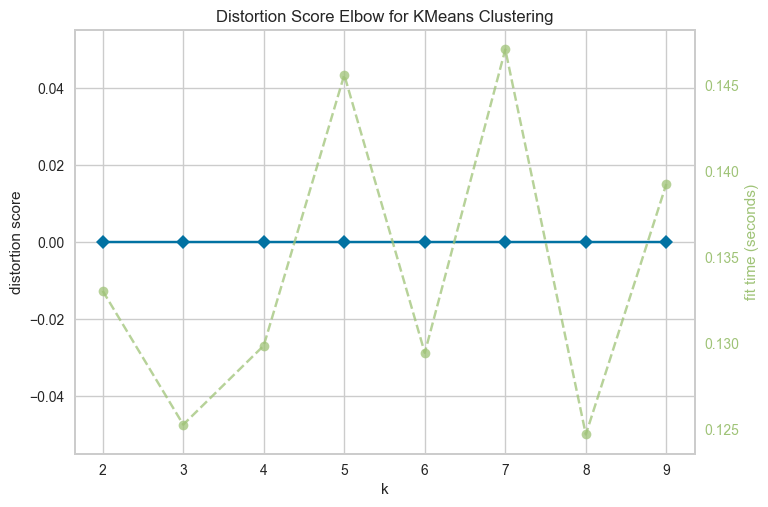

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [81]:
km = KMeans(random_state = 42)
visualizer = KElbowVisualizer(km, k = (2,10))
visualizer.fit(return_rate_per_supplier[['return_rate']])
visualizer.show()

In [82]:
data = return_rate_per_supplier
# Select the columns you want to apply KMeans on
columns = ['return_rate']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Initialize an empty dictionary to store the cluster scores for each column
cluster_scores = {}

# Apply KMeans clustering for each feature
for i, column in enumerate(columns):
    kmeans = KMeans(n_clusters=4, random_state=0)  # Use n_clusters=4 or any number based on your preference
    data[f'{column}_Cluster'] = kmeans.fit_predict(data_scaled[:, i].reshape(-1, 1))
    
    # Store the cluster labels
    cluster_scores[column] = data[f'{column}_Cluster']

# Print the dataframe with cluster labels
data

supplier_id  return_rate  return_rate_Cluster
0              1         0.00                    0
1              2         0.00                    0
2              3         0.00                    0
3              4         0.00                    0
4              5         0.00                    0
..           ...          ...                  ...
995          996         0.00                    0
996          997         0.00                    0
997          998         0.00                    0
998          999         0.00                    0
999         1000         0.00                    0

[1000 rows x 3 columns]

In [83]:
for i in ['return_rate']:
    column = i
    print(column)
    for j in range(0,4):
        print(f"Score {j} ranges from : {data[column][data[f'{column}_Cluster'] == j].min()} to {data[column][data[f'{column}_Cluster'] == j].max()}")

return_rate
Score 0 ranges from : 0.0 to 0.0
Score 1 ranges from : nan to nan
Score 2 ranges from : nan to nan
Score 3 ranges from : nan to nan


In [84]:
df['order_month'] = df['order_date'].dt.month
df['order_quarter'] = df['order_date'].dt.quarter
seasonal_return_trends = df.groupby(['order_month', 'order_quarter'])['is_returned'].mean().reset_index()
seasonal_return_trends

order_month  order_quarter  is_returned
0             1              1         0.00
1             2              1         0.00
2             3              1         0.00
3             4              2         0.00
4             5              2         0.00
5             6              2         0.00
6             7              3         0.00
7             8              3         0.00
8             9              3         0.00
9            10              4         0.00
10           11              4         0.00
11           12              4         0.00

In [85]:
# Function to calculate RFM
def calculate_rfm(df, customer_id_col, order_id_col, order_date_col, order_value_col, snapshot_date=None):
    """
    Calculate RFM (Recency, Frequency, and Monetary) values for customers.

    Parameters:
    df (pd.DataFrame): DataFrame containing customer data.
    customer_id_col (str): The column name for the customer ID.
    order_date_col (str): The column name for the order date.
    order_value_col (str): The column name for the order value.
    snapshot_date (str or datetime, optional): The date to calculate recency against (default is today).

    Returns:
    pd.DataFrame: DataFrame with customer_id, Recency, Frequency, and Monetary values.
    """

    # Set the snapshot date (for recency calculation), default is today if not provided
    if snapshot_date is None:
        snapshot_date = datetime.today()
    else:
        snapshot_date = pd.to_datetime(snapshot_date)
    
    # Ensure the order_date_col is in datetime format
    df[order_date_col] = pd.to_datetime(df[order_date_col])
    
    # Ensure that only delivered / exchanged orders are accounted for monetary calculation
    filtered_df = df[df['order_status'].isin(['delivered', 'exchanged'])]
    filtered_df = filtered_df.groupby(customer_id_col).agg({order_value_col : 'sum'}).reset_index()

    # Calculate Recency: difference between the snapshot date and the last order date
    rfm_df = df.groupby(customer_id_col).agg({
        order_date_col: lambda x: (snapshot_date - x.max()).days,  # Recency
        order_id_col: 'count',  # Frequency
    }).reset_index()
    
    # Merging the DataFrames on 'user_id'
    merged_df = pd.merge(rfm_df, filtered_df, on=customer_id_col, how='left')

    # Replacing NaN values with 0
    merged_df[order_value_col] = merged_df[order_value_col].fillna(0)

    # Rename columns to Recency, Frequency, and Monetary
    merged_df.columns = [customer_id_col, 'Recency', 'Frequency', 'Monetary']

    return merged_df

In [86]:
# Function to map feedback and calculate the weighted feedback score
def calculate_feedback(df, customer_id_col, feedback_col, feedback_date_col, today, recent_threshold=30, alpha=0.7, beta=0.3):
    """
    Function to map feedback to a numerical score and calculate weighted feedback based on recency.
    
    Parameters:
    df (pd.DataFrame): The input dataframe with feedback data.
    customer_id_col (str): The column name for the customer ID.
    feedback_col (str): Column name for feedback (positive/negative/neutral).
    feedback_date_col (str): Column name for feedback date.
    today (str): The last date / latest date wrt which the recency will be calculated.
    recent_threshold (int): Number of days to classify feedback as 'recent'. Default is 30 days.
    alpha (float): Weight for recent feedback. Default is 0.7.
    beta (float): Weight for older feedback. Default is 0.3.
    
    Returns:
    pd.DataFrame: DataFrame with the weighted feedback scores.
    """

    # Step 1: Map the feedback to numerical scores
    feedback_mapping = {
        'Positive feedback': 1,
        'Neutral feedback': 0,
        'Negative feedback': -1
    }
    df['feedback_mapped'] = df[feedback_col].map(feedback_mapping)
    
    # Convert feedback_date_col to datetime if not already
    df[feedback_date_col] = pd.to_datetime(df[feedback_date_col])
    
    # Step 2: Calculate days since feedback was provided
    if not today :
        today = pd.to_datetime("today")
    df['days_since_feedback'] = (today - df[feedback_date_col]).dt.days
    
    # Step 3: Classify feedback as 'recent' or 'older'
    df['feedback_type'] = df['days_since_feedback'].apply(lambda x: 'recent' if x <= recent_threshold else 'older')
    
    # Step 4: Calculate the weighted feedback score based on recency
    df['weighted_feedback'] = df.apply(lambda x: alpha * x['feedback_mapped'] if x['feedback_type'] == 'recent' 
                                       else beta * x['feedback_mapped'], axis=1)
    
    # Step 5: Group the by customer_id and sum the weighted scores
    feedback_df = df.groupby(customer_id_col).agg({
        'weighted_feedback': 'sum'
    }).reset_index()

    # Rename columns to Recency, Frequency, and Monetary
    feedback_df.columns = [customer_id_col, 'Weighted Feedback Score']
    
    return feedback_df

In [87]:
# Function to map feedback and calculate the weighted feedback score
def calculate_interaction(df, customer_id_col, clicks_count_col, app_open_count_col, alpha=1, beta=2):
    """
    Function to map feedback to a numerical score and calculate weighted feedback based on recency.
    
    Parameters:
    df (pd.DataFrame): The input dataframe with feedback data.
    customer_id_col (str): The column name for the customer ID.
    clicks_count_col (str): Column name for number of clicks.
    app_open_count_col (str): Column name for number of times the app was opened.
    alpha (float): Weight for app opens. Default is 1.
    beta (float): Weight for clicks. Default is 2.
    
    Returns:
    pd.DataFrame: DataFrame with the weighted feedback scores.
    """

    
    # Step 4: Calculate the weighted feedback score based on recency
    df['weighted_interaction_score'] = df.apply(lambda x: alpha * x[app_open_count_col] + beta * x[clicks_count_col], axis=1)
    
    # Step 5: Group the by customer_id and sum the weighted scores
    interaction_df = df.groupby(customer_id_col).agg({
        'weighted_interaction_score': 'sum'
    }).reset_index()

    # Rename columns to Recency, Frequency, and Monetary
    interaction_df.columns = [customer_id_col, 'Weighted Interaction Score']
    
    return interaction_df

In [88]:
max_date = df['order_date'].max()
x = calculate_rfm(df,'user_id','order_id','order_date','order_value',max_date)
y = calculate_feedback(df,'user_id','feedback','order_date',max_date)
z = calculate_interaction(df,'user_id','clicks_count','app_open_count')
x['Feedback'] = y['Weighted Feedback Score']
x['Interaction'] = z['Weighted Interaction Score']
x

user_id  Recency  Frequency  Monetary  Feedback  Interaction
0            1       17          6  18845.53     -0.30          265
1            2      111          6   7088.22      1.20          247
2            3       12          3   6241.12      0.10          104
3            4       81          4  13920.68     -1.20          115
4            5       88          3   6851.89     -0.90           95
...        ...      ...        ...       ...       ...          ...
98462    99996       99          4   9310.30     -0.60          251
98463    99997       13          2   5169.92     -0.30           99
98464    99998       44          5   9319.30     -0.90          329
98465    99999       23          5   7943.73     -0.40          256
98466   100000      113          3   8800.22      0.00          158

[98467 rows x 6 columns]

In [89]:
data = x
# Select the columns you want to apply KMeans on
columns = ['Recency', 'Frequency', 'Monetary', 'Feedback', 'Interaction']

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Initialize an empty dictionary to store the cluster scores for each column
cluster_scores = {}

# Apply KMeans clustering for each feature
for i, column in enumerate(columns):
    kmeans = KMeans(n_clusters=4, random_state=0)  # Use n_clusters=4 or any number based on your preference
    data[f'{column}_Cluster'] = kmeans.fit_predict(data_scaled[:, i].reshape(-1, 1))
    
    # Store the cluster labels
    cluster_scores[column] = data[f'{column}_Cluster']

# Print the dataframe with cluster labels
data

user_id  Recency  Frequency  Monetary  Feedback  Interaction  \
0            1       17          6  18845.53     -0.30          265   
1            2      111          6   7088.22      1.20          247   
2            3       12          3   6241.12      0.10          104   
3            4       81          4  13920.68     -1.20          115   
4            5       88          3   6851.89     -0.90           95   
...        ...      ...        ...       ...       ...          ...   
98462    99996       99          4   9310.30     -0.60          251   
98463    99997       13          2   5169.92     -0.30           99   
98464    99998       44          5   9319.30     -0.90          329   
98465    99999       23          5   7943.73     -0.40          256   
98466   100000      113          3   8800.22      0.00          158   

       Recency_Cluster  Frequency_Cluster  Monetary_Cluster  Feedback_Cluster  \
0                    0                  0                 0                 3   
1                    3                  0                 2                 0   
2                    0                  1                 1                 3   
3                    3                  1                 3                 2   
4                    3                  1                 2                 1   
...                ...                ...               ...               ...   
98462                3                  1                 2                 1   
98463                0                  3                 1                 3   
98464                0                  0                 2                 1   
98465                0                  0                 2                 3   
98466                3                  1                 2                 3   

       Interaction_Cluster  
0                        0  
1                        0  
2                        3  
3                        3  
4                        3  
...                    ...  
98462                    0  
98463                    3  
98464                    0  
98465                    0  
98466                    1  

[98467 rows x 11 columns]

In [90]:
mapping = {
    0: 3,
    2: 2,
    3: 1,
    1: 0
}
data['Recency_Score'] = data['Recency_Cluster'].map(mapping)
mapping = {
    3: 3,
    0: 2,
    2: 1,
    1: 0
}
data['Frequency_Score'] = data['Frequency_Cluster'].map(mapping)
mapping = {
    3: 3,
    2: 2,
    0: 1,
    1: 0
}
data['Monetary_Score'] = data['Monetary_Cluster'].map(mapping)
mapping = {
    3: 3,
    2: 2,
    0: 1,
    1: 0
}
data['Feedback_Score'] = data['Feedback_Cluster'].map(mapping)
mapping = {
    1: 3,
    3: 2,
    2: 0,
    0: 1
}
data['Interaction_Score'] = data['Interaction_Cluster'].map(mapping)
data

user_id  Recency  Frequency  Monetary  Feedback  Interaction  \
0            1       17          6  18845.53     -0.30          265   
1            2      111          6   7088.22      1.20          247   
2            3       12          3   6241.12      0.10          104   
3            4       81          4  13920.68     -1.20          115   
4            5       88          3   6851.89     -0.90           95   
...        ...      ...        ...       ...       ...          ...   
98462    99996       99          4   9310.30     -0.60          251   
98463    99997       13          2   5169.92     -0.30           99   
98464    99998       44          5   9319.30     -0.90          329   
98465    99999       23          5   7943.73     -0.40          256   
98466   100000      113          3   8800.22      0.00          158   

       Recency_Cluster  Frequency_Cluster  Monetary_Cluster  Feedback_Cluster  \
0                    0                  0                 0                 3   
1                    3                  0                 2                 0   
2                    0                  1                 1                 3   
3                    3                  1                 3                 2   
4                    3                  1                 2                 1   
...                ...                ...               ...               ...   
98462                3                  1                 2                 1   
98463                0                  3                 1                 3   
98464                0                  0                 2                 1   
98465                0                  0                 2                 3   
98466                3                  1                 2                 3   

       Interaction_Cluster  Recency_Score  Frequency_Score  Monetary_Score  \
0                        0              3                2               1   
1                        0              1                2               2   
2                        3              3                0               0   
3                        3              1                0               3   
4                        3              1                0               2   
...                    ...            ...              ...             ...   
98462                    0              1                0               2   
98463                    3              3                3               0   
98464                    0              3                2               2   
98465                    0              3                2               2   
98466                    1              1                0               2   

       Feedback_Score  Interaction_Score  
0                   3                  1  
1                   1                  1  
2                   3                  2  
3                   2                  2  
4                   0                  2  
...               ...                ...  
98462               0                  1  
98463               3                  2  
98464               0                  1  
98465               3                  1  
98466               3                  3  

[98467 rows x 16 columns]

In [91]:
copy = data[['user_id','Recency','Frequency','Monetary','Feedback','Interaction','Recency_Score','Frequency_Score','Monetary_Score','Feedback_Score','Interaction_Score']]
copy['Overall_Score'] = (
    copy['Recency_Score'] +
    copy['Frequency_Score'] +
    copy['Monetary_Score'] +
    copy['Feedback_Score'] +
    copy['Interaction_Score']
)
copy

user_id  Recency  Frequency  Monetary  Feedback  Interaction  \
0            1       17          6  18845.53     -0.30          265   
1            2      111          6   7088.22      1.20          247   
2            3       12          3   6241.12      0.10          104   
3            4       81          4  13920.68     -1.20          115   
4            5       88          3   6851.89     -0.90           95   
...        ...      ...        ...       ...       ...          ...   
98462    99996       99          4   9310.30     -0.60          251   
98463    99997       13          2   5169.92     -0.30           99   
98464    99998       44          5   9319.30     -0.90          329   
98465    99999       23          5   7943.73     -0.40          256   
98466   100000      113          3   8800.22      0.00          158   

       Recency_Score  Frequency_Score  Monetary_Score  Feedback_Score  \
0                  3                2               1               3   
1                  1                2               2               1   
2                  3                0               0               3   
3                  1                0               3               2   
4                  1                0               2               0   
...              ...              ...             ...             ...   
98462              1                0               2               0   
98463              3                3               0               3   
98464              3                2               2               0   
98465              3                2               2               3   
98466              1                0               2               3   

       Interaction_Score  Overall_Score  
0                      1             10  
1                      1              7  
2                      2              8  
3                      2              8  
4                      2              5  
...                  ...            ...  
98462                  1              4  
98463                  2             11  
98464                  1              8  
98465                  1             11  
98466                  3              9  

[98467 rows x 12 columns]

In [92]:
for i in ['Recency', 'Frequency', 'Monetary', 'Feedback', 'Interaction']:
    column = i
    print(column)
    for j in range(0,4):
        print(f"Score {j} ranges from : {copy[column][copy[f'{column}_Score'] == j].min()} to {copy[column][copy[f'{column}_Score'] == j].max()}")

Recency
Score 0 ranges from : 125 to 218
Score 1 ranges from : 56 to 124
Score 2 ranges from : 219 to 364
Score 3 ranges from : 0 to 55
Frequency
Score 0 ranges from : 3 to 4
Score 1 ranges from : 8 to 15
Score 2 ranges from : 5 to 7
Score 3 ranges from : 1 to 2
Monetary
Score 0 ranges from : 1.78 to 6646.62
Score 1 ranges from : 18343.010000000002 to 41488.58
Score 2 ranges from : 6647.08 to 11915.380000000001
Score 3 ranges from : 11916.61 to 18342.15
Feedback
Score 0 ranges from : -1.0 to -0.5
Score 1 ranges from : 0.19999999999999996 to 2.4
Score 2 ranges from : -3.9 to -1.0999999999999999
Score 3 ranges from : -0.39999999999999997 to 0.09999999999999998
Interaction
Score 0 ranges from : 368 to 872
Score 1 ranges from : 236 to 367
Score 2 ranges from : 0 to 127
Score 3 ranges from : 128 to 235


In [93]:
copy['return_rate'] = return_rate_per_user['return_rate']
copy.set_index('user_id',inplace = True)
copy

Recency  Frequency  Monetary  Feedback  Interaction  Recency_Score  \
user_id                                                                       
1             17          6  18845.53     -0.30          265              3   
2            111          6   7088.22      1.20          247              1   
3             12          3   6241.12      0.10          104              3   
4             81          4  13920.68     -1.20          115              1   
5             88          3   6851.89     -0.90           95              1   
...          ...        ...       ...       ...          ...            ...   
99996         99          4   9310.30     -0.60          251              1   
99997         13          2   5169.92     -0.30           99              3   
99998         44          5   9319.30     -0.90          329              3   
99999         23          5   7943.73     -0.40          256              3   
100000       113          3   8800.22      0.00          158              1   

         Frequency_Score  Monetary_Score  Feedback_Score  Interaction_Score  \
user_id                                                                       
1                      2               1               3                  1   
2                      2               2               1                  1   
3                      0               0               3                  2   
4                      0               3               2                  2   
5                      0               2               0                  2   
...                  ...             ...             ...                ...   
99996                  0               2               0                  1   
99997                  3               0               3                  2   
99998                  2               2               0                  1   
99999                  2               2               3                  1   
100000                 0               2               3                  3   

         Overall_Score  return_rate  
user_id                              
1                   10         0.14  
2                    7         0.46  
3                    8         0.38  
4                    8         0.36  
5                    5         0.33  
...                ...          ...  
99996                4         0.17  
99997               11         0.54  
99998                8         0.33  
99999               11         0.27  
100000               9         0.00  

[98467 rows x 12 columns]

In [94]:
# Assuming 'aov' is your DataFrame containing 'user_id' and 'AOV'
# Rename the AOV column in 'aov' to avoid suffixes
aov.rename(columns={'AOV': 'AOV_new'}, inplace=True)

# Now merge with the 'copy' DataFrame
copy = pd.merge(copy, aov[['user_id', 'AOV_new']], on='user_id', how='left')

# If needed, rename the column back to AOV
copy.rename(columns={'AOV_new': 'AOV'}, inplace=True)

# Display the updated copy DataFrame
copy


user_id  Recency  Frequency  Monetary  Feedback  Interaction  \
0            1       17          6  18845.53     -0.30          265   
1            2      111          6   7088.22      1.20          247   
2            3       12          3   6241.12      0.10          104   
3            4       81          4  13920.68     -1.20          115   
4            5       88          3   6851.89     -0.90           95   
...        ...      ...        ...       ...       ...          ...   
98462    99996       99          4   9310.30     -0.60          251   
98463    99997       13          2   5169.92     -0.30           99   
98464    99998       44          5   9319.30     -0.90          329   
98465    99999       23          5   7943.73     -0.40          256   
98466   100000      113          3   8800.22      0.00          158   

       Recency_Score  Frequency_Score  Monetary_Score  Feedback_Score  \
0                  3                2               1               3   
1                  1                2               2               1   
2                  3                0               0               3   
3                  1                0               3               2   
4                  1                0               2               0   
...              ...              ...             ...             ...   
98462              1                0               2               0   
98463              3                3               0               3   
98464              3                2               2               0   
98465              3                2               2               3   
98466              1                0               2               3   

       Interaction_Score  Overall_Score  return_rate     AOV  
0                      1             10         0.14 3140.92  
1                      1              7         0.46 1181.37  
2                      2              8         0.38 2080.37  
3                      2              8         0.36 3480.17  
4                      2              5         0.33 2283.96  
...                  ...            ...          ...     ...  
98462                  1              4         0.17 2327.57  
98463                  2             11         0.54 2584.96  
98464                  1              8         0.33 1863.86  
98465                  1             11         0.27 1588.75  
98466                  3              9         0.00 2933.41  

[98467 rows x 14 columns]

In [95]:
copy['AOV'].isna().sum()

0

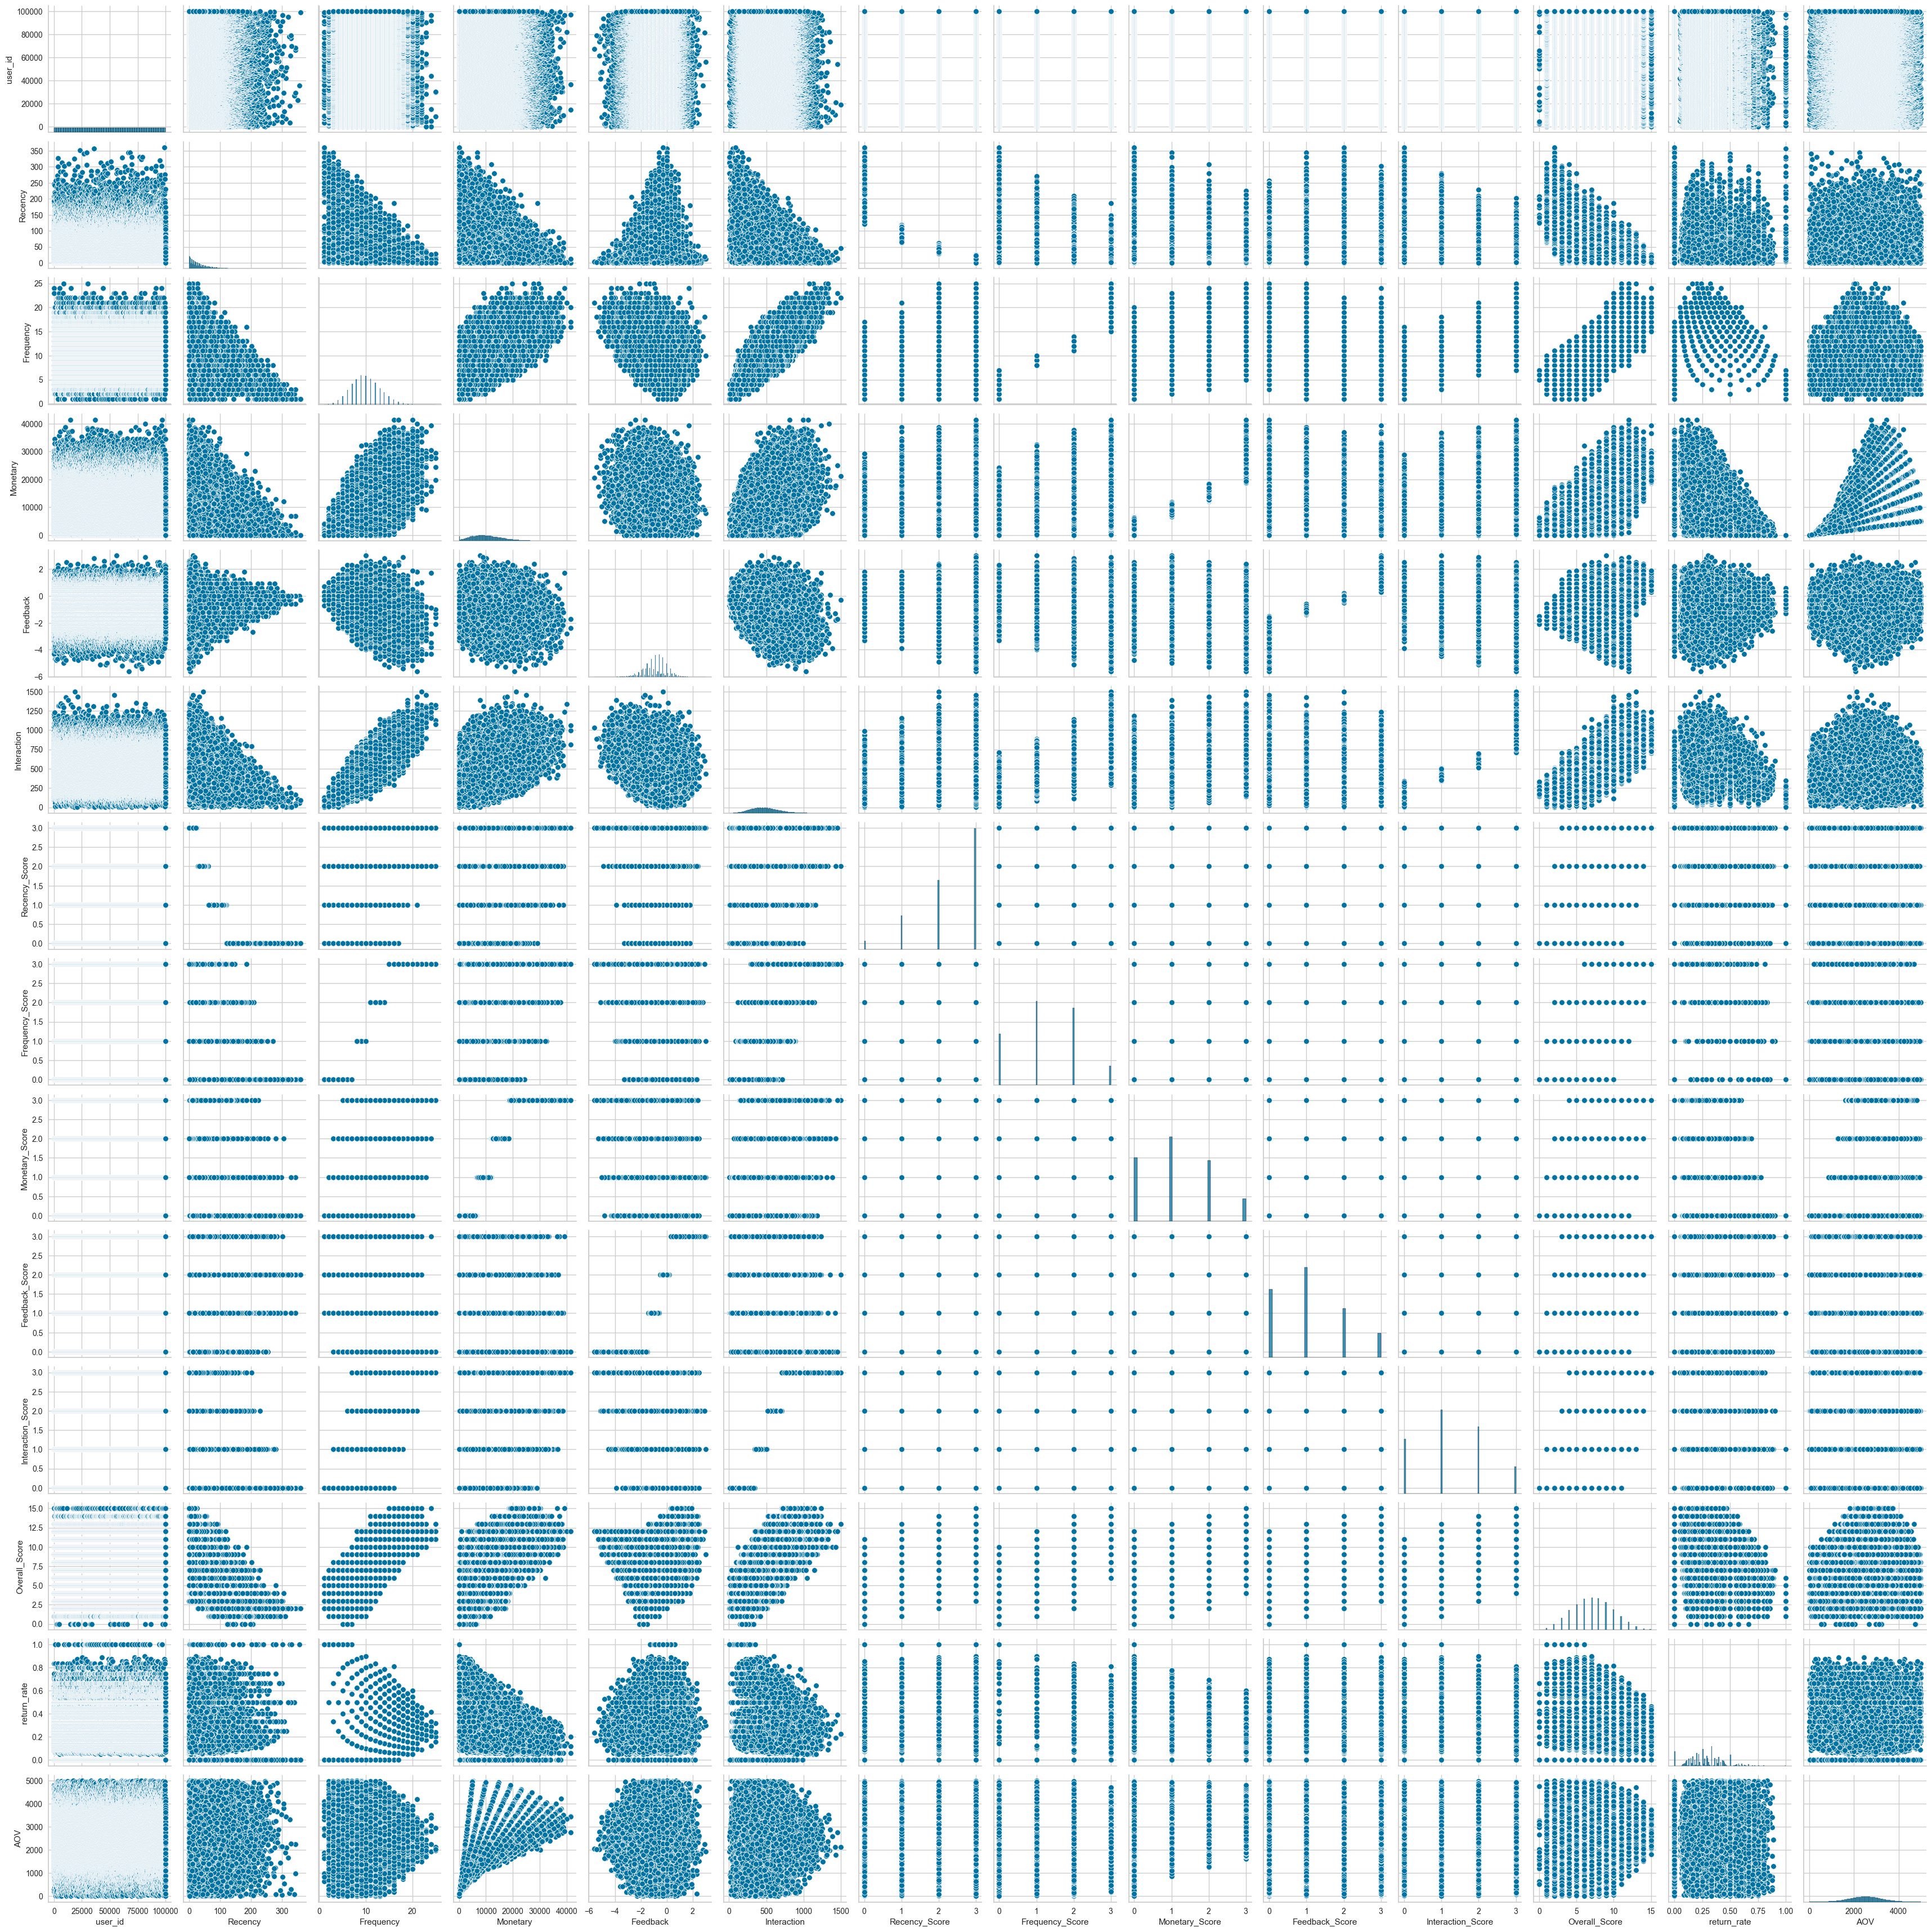

In [67]:
sns.pairplot(copy)

In [96]:
import pycaret.classification as clf
import pycaret.regression as reg
from pycaret.classification import *

In [97]:
# REGRESSION ---------
reg_setup = reg.setup(
            data = copy,
            target = 'AOV',
            train_size = 0.8,
            normalize = True,
            session_id = 123,
            verbose = True,
            log_experiment = False)
xgb_reg_model = reg.create_model('xgboost')
reg_predictions_data = reg.predict_model(xgb_reg_model, data = copy)\
                       .sort_values('prediction_label', ascending = False)

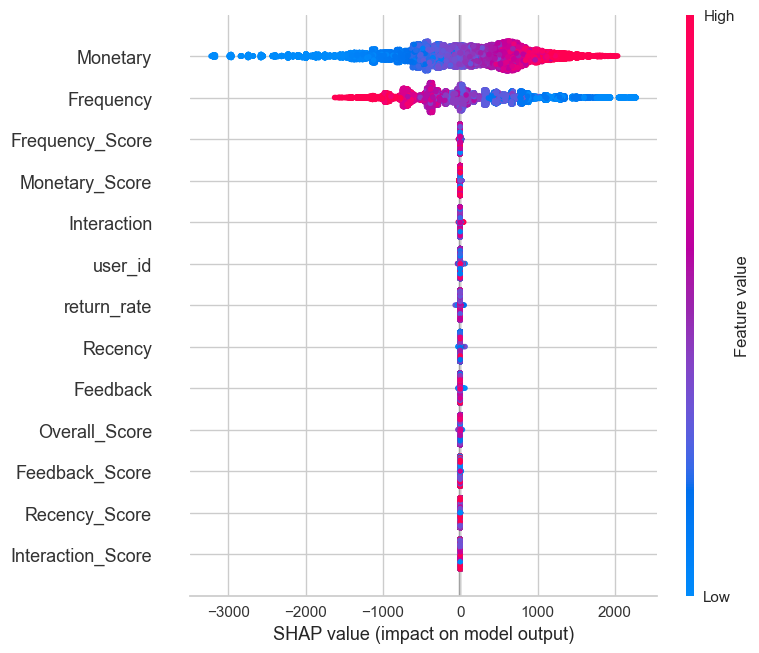

In [98]:
reg.interpret_model(xgb_reg_model)

In [ ]:
return_rate_per_rfm = copy.groupby('Overall_Score')['return_rate'].mean().reset_index()
return_rate_per_rfm.columns = ['Recency_Score', 'return_rate']
return_rate_per_rfm